In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("./data/tweets_features.csv", encoding='latin')
df.drop(['is_after_certain_day', 'Date', 'User', 'Text', 'Time', 'Full_date'], axis=1, inplace=True)

In [3]:
df.head()

,Target,Weekday,Length,Hashtags,HasHashtags,Mentions,HasMentions,ExclamationMarks,HasExclamationMarks,Emoticons,...,w2v_90,w2v_91,w2v_92,w2v_93,w2v_94,w2v_95,w2v_96,w2v_97,w2v_98,w2v_99
0,0,4,111,0,False,0,False,0,False,[],...,0.576463,0.272287,-0.270659,0.398829,0.806970,0.539171,0.261823,-0.655965,0.179224,-0.132590
1,0,2,131,0,False,0,False,0,False,[],...,0.400095,0.262307,0.052329,0.443299,0.895985,0.565586,0.221301,-0.797784,0.020691,0.002357
2,0,1,41,0,False,1,True,2,True,[],...,0.460558,0.378846,-0.171764,0.227248,0.303033,0.620672,0.146584,-0.615910,0.112132,-0.088989
3,0,6,72,0,False,0,False,0,False,[],...,0.535103,0.073591,-0.307203,0.651506,0.309582,0.018715,-0.205674,-0.595330,0.333111,0.001450
4,1,0,57,0,False,1,True,0,False,[],...,0.484578,0.324513,-0.259205,0.183831,0.745856,0.448028,0.359533,-0.555516,-0.176974,-0.091381


In [4]:
selected_columns = ['Negative_VADER', 'skewed_hour_dist', 'Weekday', 'Compound_VADER',
                    'skewed_week_dist', 'w2v_11', 'Mentions', 'Polarity_TB', 'w2v_27',
                    'w2v_53', 'Hour', 'w2v_44', 'w2v_84', 'embedding_16']

df = df[selected_columns + ['Target']]

In [5]:
def evaluate_classifiers(X, y, classifiers, param_distributions, cv_folds=5, n_iter=10):
    results = {}
    best_models = {}
    for name, clf in classifiers.items():
        pipeline = Pipeline([('scaler', StandardScaler()), (name.lower().replace(" ", ""), clf)])
        search = TuneSearchCV(
            pipeline,
            param_distributions=param_distributions.get(name, {}),
            n_trials=n_iter,
            cv=cv_folds,
            scoring='accuracy',
            search_optimization="random",
            verbose=1,
            random_state=42
        )
        search.fit(X, y)
        best_models[name] = search.best_estimator_
        results[name] = search.cv_results_
        print(f"{name} Best Accuracy: {search.best_score_:.2f}")
        print(f"Best Parameters: {search.best_params_}")

    sorted_models = sorted(best_models.items(), key=lambda x: x[1].score(X, y), reverse=True)[:3]
    return results, sorted_models

In [6]:
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline

X = df.drop(['Target'], axis=1)
y = df['Target']
X = X.select_dtypes(include=['number'])


def objective(trial, classifier_name, model, param_grid):
    params = {}
    for key, values in param_grid.items():
        if isinstance(values, list):
            params[key] = trial.suggest_categorical(key, values)
        elif isinstance(values, tuple) and len(values) == 3 and values[2] == 'log':
            params[key] = trial.suggest_float(key, values[0], values[1], log=True)
        elif isinstance(values, tuple):
            params[key] = trial.suggest_float(key, values[0], values[1])

    clf = model(**params)
    pipeline = Pipeline([('scaler', StandardScaler()), ('classifier', clf)])
    score = cross_val_score(pipeline, X, y, n_jobs=-1, cv=5).mean()
    return score


param_grids = {
    'Logistic Regression': {'C': (1e-4, 1e4, 'log')},
    'Random Forest': {
        'n_estimators': [10, 50, 100, 200],
        'max_features': ['sqrt', 'log2']
    },
    'k-Nearest Neighbors': {'n_neighbors': list(range(1, 21))},
    'Decision Tree': {'max_depth': list(range(1, 21))},
    'Gradient Boosting': {
        'n_estimators': [10, 50, 100, 200],
        'learning_rate': [0.001, 0.01, 0.1, 1]
    },
    'Naive Bayes': {}
}



In [7]:
study_results = {}
for name, grid in param_grids.items():
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, name, {
        'Logistic Regression': LogisticRegression,
        'Random Forest': RandomForestClassifier,
        'k-Nearest Neighbors': KNeighborsClassifier,
        'Decision Tree': DecisionTreeClassifier,
        'Gradient Boosting': GradientBoostingClassifier,
        'Naive Bayes': GaussianNB
    }[name], grid), n_trials=10)

    study_results[name] = {
        'Best Score': study.best_value,
        'Best Parameters': study.best_params
    }

for classifier, result in study_results.items():
    print(f"{classifier} - Best Score: {result['Best Score']:.4f}")
    print(f"Best Parameters: {result['Best Parameters']}")

[I 2024-04-20 22:32:17,972] A new study created in memory with name: no-name-b904cb88-d6d5-4733-be45-14e7b8f54682
[I 2024-04-20 22:32:19,286] Trial 0 finished with value: 0.76877 and parameters: {'C': 0.07697054909558497}. Best is trial 0 with value: 0.76877.
[I 2024-04-20 22:32:20,026] Trial 1 finished with value: 0.7687200000000001 and parameters: {'C': 176.52933623262982}. Best is trial 0 with value: 0.76877.
[I 2024-04-20 22:32:20,748] Trial 2 finished with value: 0.7687200000000001 and parameters: {'C': 320.41231258205863}. Best is trial 0 with value: 0.76877.
[I 2024-04-20 22:32:21,376] Trial 3 finished with value: 0.7687200000000001 and parameters: {'C': 11.859485372705064}. Best is trial 0 with value: 0.76877.
[I 2024-04-20 22:32:21,624] Trial 4 finished with value: 0.7687200000000001 and parameters: {'C': 35.635677321925904}. Best is trial 0 with value: 0.76877.
[I 2024-04-20 22:32:21,868] Trial 5 finished with value: 0.76933 and parameters: {'C': 0.0012968098405506075}. Best 

Logistic Regression - Best Score: 0.7694
Best Parameters: {'C': 0.0014317830412433098}
Random Forest - Best Score: 0.7893
Best Parameters: {'n_estimators': 200, 'max_features': 'log2'}
k-Nearest Neighbors - Best Score: 0.7747
Best Parameters: {'n_neighbors': 20}
Decision Tree - Best Score: 0.7688
Best Parameters: {'max_depth': 10}
Gradient Boosting - Best Score: 0.7892
Best Parameters: {'n_estimators': 50, 'learning_rate': 1}
Naive Bayes - Best Score: 0.7513
Best Parameters: {}


In [6]:
def evaluate_ensemble_classifiers(X, y, classifiers, cv_folds=5):
    results = {}
    for name, model in classifiers.items():
        cv_scores = cross_val_score(model, X, y, cv=cv_folds, scoring='accuracy')
        results[name] = {
            'Mean Accuracy': np.mean(cv_scores),
            'Standard Deviation': np.std(cv_scores),
            'All Scores': cv_scores
        }
        print(f"{name}: Mean Accuracy = {results[name]['Mean Accuracy']:.4f}, " +
              f"Std Deviation = {results[name]['Standard Deviation']:.4f}")
    return results

In [10]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, \
    StackingClassifier, VotingClassifier

base_estimators = [
    ('DecisionTree', DecisionTreeClassifier(max_depth=10)),
    ('KNN', KNeighborsClassifier(n_neighbors=20)),
    ('LogisticRegression', LogisticRegression(C=0.0014, max_iter=1000))
]


ensemble_classifiers = {
    "Voting_Soft": VotingClassifier(estimators=base_estimators, voting='soft'),
    "AdaBoost (with Decision Tree)": AdaBoostClassifier(DecisionTreeClassifier(max_depth=10), n_estimators=50),
    "Bagging (with Logistic Regression)": BaggingClassifier(LogisticRegression(C=0.0014, max_iter=1000), n_estimators=10),
    "Stacking": StackingClassifier(estimators=base_estimators, final_estimator=GradientBoostingClassifier(n_estimators=50, learning_rate=1))
}

ensemble_classifiers_res = evaluate_ensemble_classifiers(X, y, ensemble_classifiers, cv_folds=5)

Voting_Soft: Mean Accuracy = 0.7842, Std Deviation = 0.0017


/home/adam/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/adam/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/adam/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/adam/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
 

AdaBoost (with Decision Tree): Mean Accuracy = 0.7317, Std Deviation = 0.0015
Bagging (with Logistic Regression): Mean Accuracy = 0.7573, Std Deviation = 0.0025
Stacking: Mean Accuracy = 0.7756, Std Deviation = 0.0026


In [11]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model = XGBClassifier(random_state=1,
                      learning_rate=0.01,
                      booster='gbtree',
                      max_depth=5
                      )
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.77585

In [29]:
import tensorflow as tf

early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True
)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**( -(epoch // 10))
)

model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(shape=(X.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu', activity_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X, y, epochs=50, validation_split=0.2, callbacks=[early_stopping, lr_scheduler])

model.save("./models/nn_model.keras")

Epoch 1/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 652us/step - accuracy: 0.6382 - loss: 19.3838 - val_accuracy: 0.7397 - val_loss: 0.7235 - learning_rate: 1.0000e-04
Epoch 2/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 579us/step - accuracy: 0.7474 - loss: 0.6190 - val_accuracy: 0.7703 - val_loss: 0.5019 - learning_rate: 1.0000e-04
Epoch 3/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 583us/step - accuracy: 0.7685 - loss: 0.4979 - val_accuracy: 0.7734 - val_loss: 0.4830 - learning_rate: 1.0000e-04
Epoch 4/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 579us/step - accuracy: 0.7725 - loss: 0.4855 - val_accuracy: 0.7765 - val_loss: 0.4733 - learning_rate: 1.0000e-04
Epoch 5/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 584us/step - accuracy: 0.7703 - loss: 0.4810 - val_accuracy: 0.7764 - val_loss: 0.4680 - learning_rate: 1.0000e-04
Epoch 6/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 584us/step - accuracy: 0.7744 - loss: 0.4716 - val_accuracy: 0.7803 - val_loss: 0.4635 - learning_rate: 1.0000e-04
Epoch 7/50
2500/2500 ━━━━━━━━━━━━━━━━━━

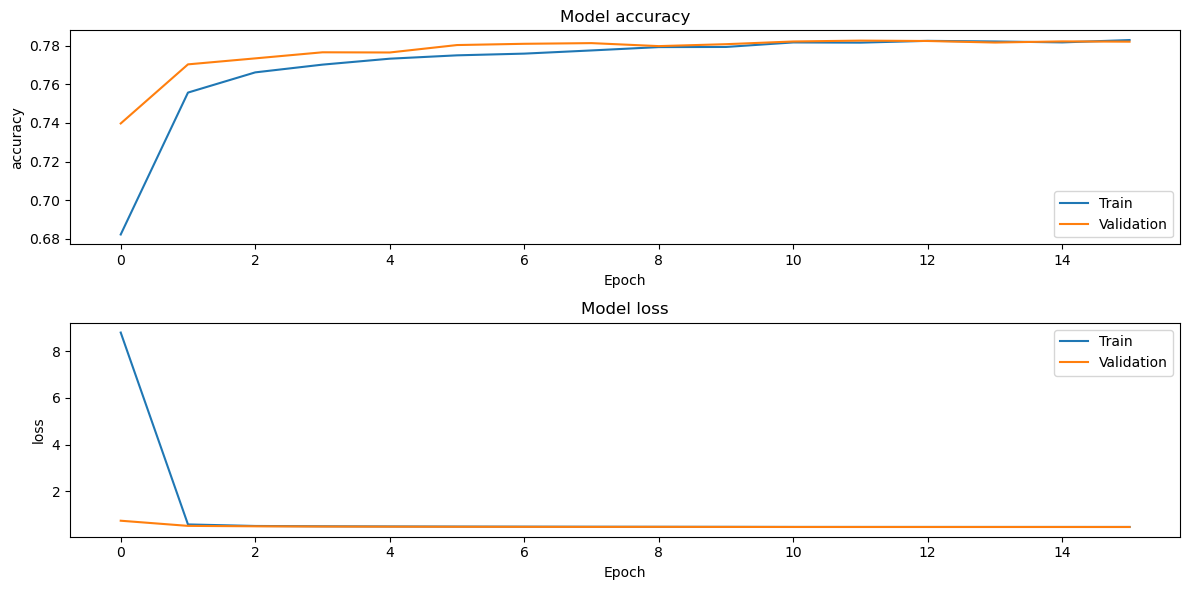

In [30]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

for i, metric in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[metric], label='Train')
    ax[i].plot(history.history[f'val_{metric}'], label='Validation')
    ax[i].set_title(f'Model {metric}')
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel(metric)
    ax[i].legend()
    
plt.tight_layout()
plt.show()